In [13]:
# Utilities
import pandas as pd
import numpy as np
from datetime import datetime, date, time, timedelta
from collections import Counter

# Plotting
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# Modelling
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

RSEED = 42

In [14]:
df = pd.read_csv("data/data_train_clean_withdummies.csv")

In [15]:
df.head()

,BatchId,AccountId,SubscriptionId,CustomerId,FraudResult,ValueUSDLog,ProviderId_2,ProviderId_3,ProviderId_4,ProviderId_5,...,DayTime_midday,DayTime_morning,DayTime_night,TransactionWeekday_2,TransactionWeekday_3,TransactionWeekday_4,TransactionWeekday_5,TransactionWeekday_6,TransactionWeekday_7,DebitCredit_1
0,36123,3957,887,4406,0,-1.272966,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,15642,4841,3829,4406,0,-5.184989,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1
2,53941,4229,222,4683,0,-1.966113,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,102363,648,2185,988,0,1.808944,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4,38780,4841,3829,988,0,-1.713022,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1


### Splitting the data

In [16]:
#separate predictor variables
X = df.drop('FraudResult', axis =1)

# separate target variable
y = df['FraudResult']


In [17]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RSEED)

### Data Balance - Oversampling

*Usefull links*:
- [SMOTE](https://imbalanced-learn.org/stable/over_sampling.html)
- [Handling Imbalanced Data Sets, Medium](https://medium.com/coinmonks/handling-imbalanced-datasets-predicting-credit-card-fraud-544f5e74e0fd)
- [Dealing with imbalanced Data, towardsdatascience](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18)

In [18]:
# apply resampling ONLY to train data
X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)

In [19]:
y_train_res

0         0
1         0
2         0
3         0
4         0
         ..
152739    1
152740    1
152741    1
152742    1
152743    1
Name: FraudResult, Length: 152744, dtype: int64

In [20]:
scaler = StandardScaler()

#standardization of train set (fit_transform)
X_train_res_stand = scaler.fit_transform(X_train_res)

#change array to dataframe
scaled_df_train_resampled = pd.DataFrame(X_train_res_stand)
scaled_df_train_resampled.columns = X_train.columns

#standardization of test set (transform)
X_test_stand = scaler.transform(X_test)

#change array to dataframe
scaled_df_test = pd.DataFrame(X_test_stand)
scaled_df_test.columns = X_test.columns

In [21]:
#scaled_df_resampled

---

## Base Line Model

>Uniform 0.499 (0.005)
>Stratified 0.500 (0.005)
>Majority 0.133 (0.267)
>Minority 0.667 (0.000)
>Prior 0.133 (0.267)


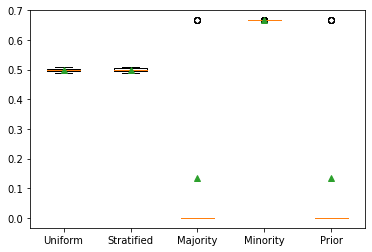

In [22]:
# compare naive classifiers with f1-measure
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from matplotlib import pyplot

# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
	return scores

# define models to test
def get_models():
	models, names = list(), list()
	# Uniformly Random Guess
	models.append(DummyClassifier(strategy='uniform'))
	names.append('Uniform')
	# Prior Random Guess
	models.append(DummyClassifier(strategy='stratified'))
	names.append('Stratified')
	# Majority Class: Predict 0
	models.append(DummyClassifier(strategy='most_frequent'))
	names.append('Majority')
	# Minority Class: Predict 1
	models.append(DummyClassifier(strategy='constant', constant=1))
	names.append('Minority')
	# Class Prior
	models.append(DummyClassifier(strategy='prior'))
	names.append('Prior')
	return models, names

# define dataset
"""
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)
"""
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
	# evaluate the model and store results
	scores = evaluate_model(scaled_df_train_resampled, y_train_res, models[i])
	results.append(scores)
	# summarize and store
	print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

### Results:

The 'Minority' `DummyClassifier` seems to deliver the best result (0.667) for a naive classifier with regards to the f1 score metric which is our goal.

In [23]:
dummy_clf = DummyClassifier(strategy="constant", constant=1)
dummy_clf.fit(scaled_df_train_resampled, y_train_res)

y_dummy_pred = dummy_clf.predict(scaled_df_train_resampled)

In [24]:
print("------"*10)
print(classification_report(y_train_res, y_dummy_pred))
print("------"*10)

# F1-score on test set
print("F1-score:", f1_score(y_train_res, y_dummy_pred, average='binary'))
print("------"*10)

f1_baseline = f1_score(y_train_res, y_dummy_pred, average='binary')

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     76372
           1       0.50      1.00      0.67     76372

    accuracy                           0.50    152744
   macro avg       0.25      0.50      0.33    152744
weighted avg       0.25      0.50      0.33    152744

------------------------------------------------------------
F1-score: 0.6666666666666666
------------------------------------------------------------


/Users/fabioteichmann/neuefische/projects/ds-ml-project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabioteichmann/neuefische/projects/ds-ml-project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/fabioteichmann/neuefische/projects/ds-ml-project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

## Modelling

### First Models

1. SVM ==> Daniela
2. LogReg ==> Kai Yang

### Advanced Models

1. Random Forest ==> Fabio
2. AdaBoost ==> 
3. Stacking ==> 

In [25]:
# save TRAIN sets
scaled_df_train_resampled.to_csv('data/x-train.csv', index=False)
y_train_res.to_csv('data/y-train.csv', index=False)

# save TEST sets
scaled_df_test.to_csv('data/x-test.csv', index=False)
y_test.to_csv('data/y-test.csv', index=False)

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

In [27]:
# Random Forest =================================
# Make a decision tree and train
tree = DecisionTreeClassifier(max_depth= None, random_state=RSEED)
tree.fit(scaled_df_train_resampled, y_train_res)

y_tree_pred = tree.predict(scaled_df_test)

In [28]:
y_tree_pred.shape

(19133,)

In [29]:
y_test.shape

(19133,)

In [30]:
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')
print(f'Model Accuracy: {tree.score(scaled_df_train_resampled, y_train_res)}')
print(f'Model F1-Score: {f1_score(y_test, y_tree_pred, average="binary")}')


Decision tree has 393 nodes with maximum depth 29.
Model Accuracy: 0.999993453097994
Model F1-Score: 0.7088607594936709


---

#### Random Forest

In [38]:
# optimal params: n_estimators=1000, criterion=entropy, max_features=sqrt
model = RandomForestClassifier(n_estimators=1000, 
                               random_state=RSEED, 
                               criterion = 'entropy',
                               max_features = 'sqrt',
                               max_depth = None,
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(scaled_df_train_resampled, y_train_res)
y_rf_pred = model.predict(scaled_df_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   19.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [39]:
print("------"*10)
print(classification_report(y_test, y_rf_pred))
print("------"*10)

# F1-score on test set
print(f'Model F1-Score: {f1_score(y_test, y_rf_pred, average="binary")}')
print("------"*10)
print("Confusion Matrix: \n", 
        confusion_matrix(y_test, y_rf_pred))

------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19097
           1       0.77      0.83      0.80        36

    accuracy                           1.00     19133
   macro avg       0.88      0.92      0.90     19133
weighted avg       1.00      1.00      1.00     19133

------------------------------------------------------------
Model F1-Score: 0.8
------------------------------------------------------------
Confusion Matrix: 
 [[19088     9]
 [    6    30]]


In [40]:
# GRID SEARCH ===========================

param_grid = {'max_features': ['sqrt', 'log2'], 
              'criterion': ['gini', 'entropy'],
              'n_estimators': [100,200,300,400,500,600,700,800,900,1000],
              'random_state': [RSEED]
             }

grid       = GridSearchCV(RandomForestClassifier(), param_grid, verbose=True, n_jobs=-1,scoring='f1')
model_rf  = grid.fit(scaled_df_train_resampled, y_train_res)
y_rf_grid_pred = model_rf.predict(scaled_df_test)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


KeyboardInterrupt: 

In [ ]:
print("------"*10)
print(classification_report(y_test, y_rf_grid_pred))
print("------"*10)

# F1-score on test set
print(f'Model F1-Score: {f1_score(y_test, y_rf_grid_pred, average="binary")}')
print("------"*10)
print("Confusion Matrix: \n", 
        confusion_matrix(y_test, y_rf_grid_pred))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Paral

Recall Baseline: 1.0 Test: 0.83 Train: 1.0
Precision Baseline: 0.0 Test: 0.77 Train: 1.0
Roc Baseline: 0.5 Test: 1.0 Train: 1.0


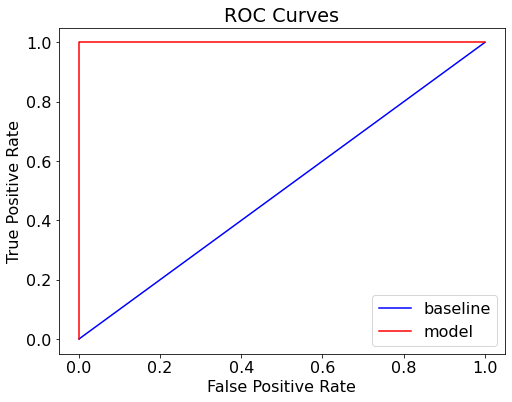

In [37]:
y_train_rf_pred = model.predict(scaled_df_train_resampled)
train_rf_probs = model.predict_proba(scaled_df_train_resampled)[:, 1]

y_rf_pred = model.predict(scaled_df_test)
rf_probs = model.predict_proba(scaled_df_test)[:, 1]
evaluate_model(y_rf_pred, rf_probs, y_train_rf_pred, train_rf_probs)

In [36]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train_res, train_predictions)
    train_results['precision'] = precision_score(y_train_res, train_predictions)
    train_results['roc'] = roc_auc_score(y_train_res, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
